In [ ]:
!pip install --upgrade tdmclient
!pip install ipython
!pip install shapely
!pip install networkx

## Importing Necessary Libraries

In [118]:
# Importing libraries
from PIL import Image
from IPython.display import Image, display
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt 
from shapely.geometry import LineString
from shapely.geometry import Point
from itertools import combinations
import networkx as nx
from shapely.geometry import LineString


## Loading Image


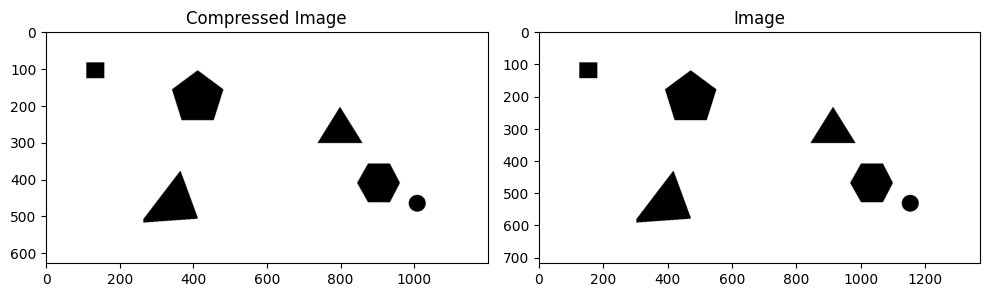

In [119]:
# Load the image
#filename = 'visibility.png'
#filename = 'visibility_bis.png'
filename = 'testImages.png'

img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# Define the desired dimensions
new_width = 1200
new_height = 1000

# Define a kernel for dilation
kernel = np.ones((3, 3), np.uint8)


# Calculate the scaling factor to maintain aspect ratio
width, height = img.shape[1], img.shape[0]
aspect_ratio = width / height

if width / new_width > height / new_height:
    new_height = int(new_width / aspect_ratio)
else:
    new_width = int(new_height * aspect_ratio)

# Resize the image while preserving the aspect ratio
compressed_img = cv2.resize(img, (new_width, new_height))
comp_height, comp_width = compressed_img.shape

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].imshow(compressed_img, cmap='gray')
axes[0].set_title('Compressed Image')
axes[0].axis('on')

# Display the second image (other_image)
axes[1].imshow(img, cmap='gray')
axes[1].set_title('Image')
axes[1].axis('on')

plt.tight_layout()
plt.show()

## Filtering and Enhancing Edges

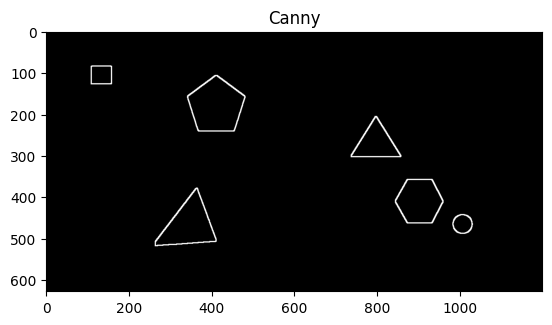

In [120]:
lower_threshold = 100
upper_threshold = 150
aperture_size = 7 # Increase if want more details

canny_img = cv2.Canny(compressed_img, lower_threshold, upper_threshold, apertureSize=aperture_size, L2gradient = True)
# Apply dilation to make edges thicker
dilated_edges = cv2.dilate(canny_img, kernel, iterations=1)

# Save the enhanced edges image
plt.imshow(dilated_edges, cmap='gray');
plt.title('Canny'); plt.axis('on');

## Scaling Contours

In [121]:
def scale_contour(cnt, scale_factor):
    # Get the bounding rectangle around the triangle
    x, y, w, h = cv2.boundingRect(cnt)

    # Calculate the center of the bounding rectangle
    center = ((x + w // 2), (y + h // 2))

    # Scale each point of the contour relative to the center
    scaled_cnt = np.array([[(point[0][0] - center[0]) * scale_factor + center[0],
                            (point[0][1] - center[1]) * scale_factor + center[1]]
                           for point in cnt], dtype=np.int32)

    return scaled_cnt

## Using contour for detecting the edges of the vertices

In [122]:
# FACTOR TO INCREASE THE SIZE OF THE OBSTACLES TO ACCOUNT FOR THE THICKNESS OF THYMIO
scale_factor = 1.4

In [132]:
shape_vertices = []
shape_edges = []

(contours, _) = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def detectShape(c):          #Function to determine type of polygon on basis of number of sides
       shape = 'unknown' 
       peri=cv2.arcLength(cnt,True) 
       vertices = cv2.approxPolyDP(cnt, 0.02 * peri, True)
       sides = len(vertices) 
       if (sides == 3): 
            shape='triangle' 
       elif(sides==4): 
             x,y,w,h=cv2.boundingRect(cnt)
             aspectratio=float(w)/h 
             if (aspectratio==1):
                   shape='square'
             else:
                   shape="rectangle" 
       elif(sides==5):
            shape='pentagon' 
       elif(sides==6):
            shape='hexagon' 
       elif(sides==8): 
            shape='octagon' 
       elif(sides==10): 
            shape='star'
       else:
           shape='circle' 
       return shape 

for cnt in contours:
    shape = detectShape(cnt)
    print('shape', shape)
    
    ## the approxPolyDP creates a octogon to approximate the circle
    if shape == 'octagon':
        (XGoal,YGoal), radius = cv2.minEnclosingCircle(cnt)
        (XGoal,YGoal)= (int(XGoal),int(YGoal))
        radius = int(radius)
        continue
        
    # This will be the initial position of the robot starting top left corner   
    elif shape == 'rectangle':
        Xrob,Yrob,Wrob,Hrob=cv2.boundingRect(cnt)
        # Calculate the center of the rectangle
        Xrob_center = Xrob + Wrob // 2
        Yrob_center = Yrob + Hrob // 2
        continue
    
    # for shapes that are not the goal, increase the size to account for thickness of thymio
    cnt = scale_contour(cnt, scale_factor)
    
    vertices = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    shape = []  # Store vertices for each shape
    edges = []  # Store lines for each shape
    
    for i, vertex in enumerate(vertices):
        x, y = vertex[0]
        shape.append((x, y))

        next_index = 0 if i == len(vertices) - 1 else i + 1
        next_vertex = vertices[next_index][0]
        ## plotting vertex locations
        cv2.circle(canny_img, (x, y), 5, (255, 0, 0), -1)  
        cv2.putText(canny_img, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0,  0), 2)

        # Append edges/lines
        edges.append(((x, y), (next_vertex[0], next_vertex[1])))

    shape_vertices.append(shape)  # Append the vertices to the list
    shape_edges.append(edges)  # Append the edges to the list
         

    
print((Xrob_center,Yrob_center))
print(shape_vertices)
print(shape_edges)



shape octagon
shape triangle
shape hexagon
shape triangle
shape pentagon
shape rectangle
(134, 106)
[[(377, 349), (233, 547), (441, 531)], [(861, 335), (821, 418), (861, 485), (946, 485), (984, 415), (952, 343)], [(712, 315), (883, 322), (800, 185)], [(406, 78), (312, 148), (344, 258), (472, 269), (510, 150)]]
[[((377, 349), (233, 547)), ((233, 547), (441, 531)), ((441, 531), (377, 349))], [((861, 335), (821, 418)), ((821, 418), (861, 485)), ((861, 485), (946, 485)), ((946, 485), (984, 415)), ((984, 415), (952, 343)), ((952, 343), (861, 335))], [((712, 315), (883, 322)), ((883, 322), (800, 185)), ((800, 185), (712, 315))], [((406, 78), (312, 148)), ((312, 148), (344, 258)), ((344, 258), (472, 269)), ((472, 269), (510, 150)), ((510, 150), (406, 78))]]


## Displaying the scaled Contour

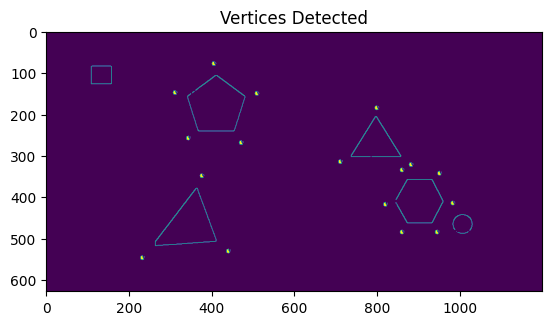

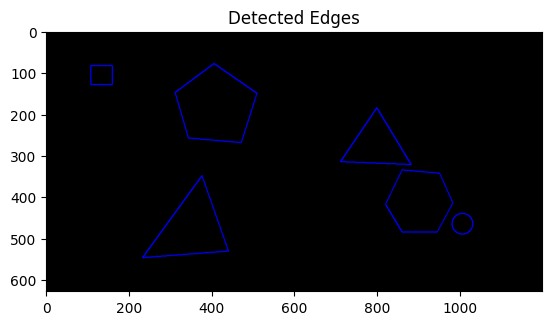

[[((521, 312), (412, 452)), ((412, 452), (566, 442)), ((566, 442), (521, 312))]]


In [133]:
# Display the initial image with highlighted vertices
plt.imshow(canny_img)
plt.title('Vertices Detected')
plt.show()

# Create a blank image
blank_img = np.zeros((comp_height, comp_width, 3), np.uint8)

# Plot the lines for each shape
for edges in shape_edges:
    for edge in edges:
        cv2.line(blank_img, edge[0], edge[1], (0, 0, 255), 2)

# Draw the final position
cv2.circle(blank_img, (XGoal, YGoal), int(radius), (0, 0, 255), 2)


# Draw the robot position
cv2.rectangle(blank_img, (Xrob, Yrob), (Xrob + Wrob, Yrob + Hrob), (0, 0, 255), 2)

plt.imshow(blank_img)
plt.title('Detected Edges')
plt.axis('on')
plt.show()
print(triangle_edges)

## Creating optimal path to traverse through contours
Using PyVisGraph library, which creates an visiblity graph and uses Dijkstras algorithm to find the shortest path
Source: https://github.com/TaipanRex/pyvisgraph

In [134]:
!pip install pyvisgraph


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [135]:
import pyvisgraph as vg
polygons = []
for shape in shape_vertices:
    polygon = []
    for point in shape:
        polygon.append(vg.Point(point[0], point[1]))
    polygons.append(polygon)
    
graph = vg.VisGraph()
graph.build(polygons)

startPosition = vg.Point(Xrob_center,Yrob_center)
endPosition = vg.Point(XGoal, YGoal)

shortestPath = graph.shortest_path(startPosition, endPosition)
print(shortestPath)


output_graphfile = 'Triangle.graph'
graph.save(output_graphfile)
print('Saved visibility graph to file: {}'.format(output_graphfile))




100%|██████████| 2/2 [00:00<00:00, 125.01it/s]

[Point(134.00, 106.00), Point(344.00, 258.00), Point(861.00, 485.00), Point(946.00, 485.00), Point(1007.00, 465.00)]
Saved visibility graph to file: Triangle.graph


## Drawing Optimal Path on the original image

In [136]:
edgelist = []

for i, node in enumerate(shortestPath[:-1]):
    print(shortestPath[i])
    edgelist.append((shortestPath[i], shortestPath[i + 1]))
    
print(edgelist)

(134.00, 106.00)
(344.00, 258.00)
(861.00, 485.00)
(946.00, 485.00)
[(Point(134.00, 106.00), Point(344.00, 258.00)), (Point(344.00, 258.00), Point(861.00, 485.00)), (Point(861.00, 485.00), Point(946.00, 485.00)), (Point(946.00, 485.00), Point(1007.00, 465.00))]


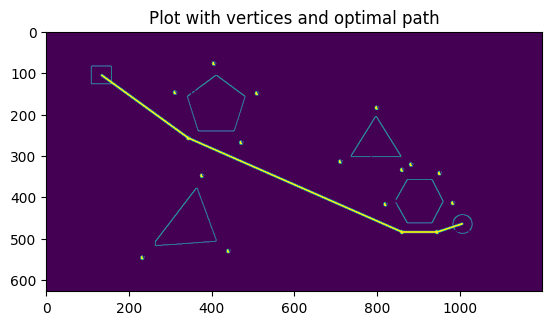

In [137]:
# Display the initial image with highlighted vertices
pathImage = canny_img.copy()
plt.title('Plot with vertices and optimal path')

color = (255, 255, 255)
thickness = 3
for i, edge in enumerate(edgelist):
    #print(int(edgelist[i][0].x), int(edgelist[i][0].y))
    cv2.line(pathImage, (int(edgelist[i][0].x), int(edgelist[i][0].y)), (int(edgelist[i][1].x), int(edgelist[i][1].y)), color, thickness)

plt.imshow(pathImage)
plt.show()